<a href="https://colab.research.google.com/github/Lois-Lanctot/student-performance-analysis/blob/main/student_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import pointbiserialr, f_oneway

!pip3 install ppscore
import ppscore as pps


# exams.csv

3 highschools in the US.

In [146]:
exams_df = pd.read_csv("/content/exams.csv")
exams_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [147]:
# exams_df.info()
print("Columns: ", exams_df.columns)
print("Record Count: ", len(exams_df))

Columns:  Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
Record Count:  1000


In [148]:
# print(exams_df.isnull().sum())

In [149]:
print(exams_df['gender'].unique())
print(exams_df['race/ethnicity'].unique())
print(exams_df['parental level of education'].unique())
print(exams_df['lunch'].unique())
print(exams_df['test preparation course'].unique())

['female' 'male']
['group D' 'group B' 'group C' 'group E' 'group A']
['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
['standard' 'free/reduced']
['completed' 'none']


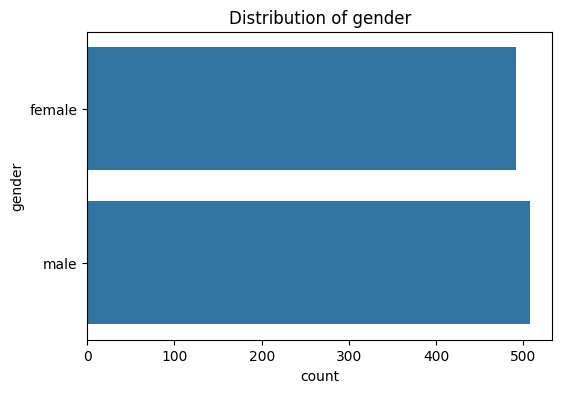

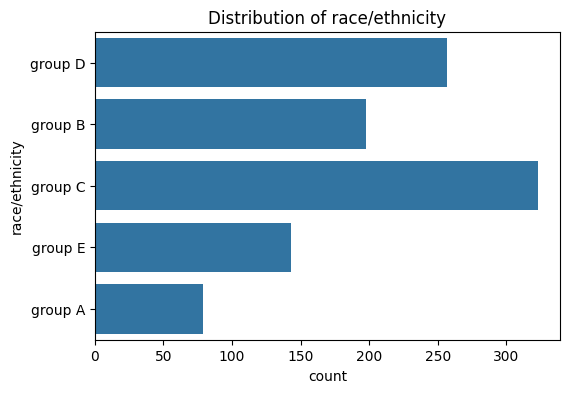

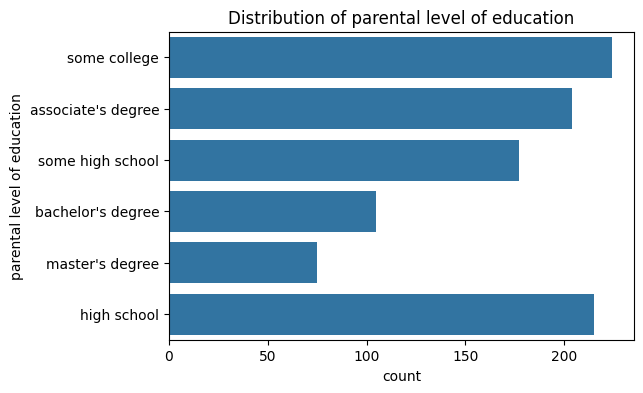

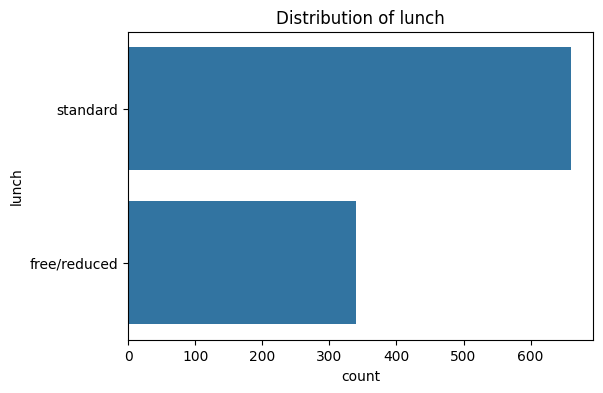

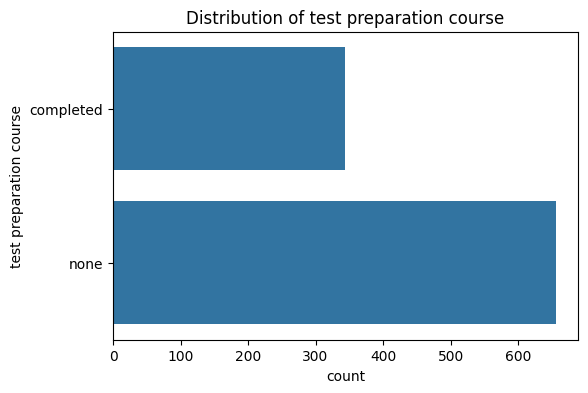

In [150]:
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(exams_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()


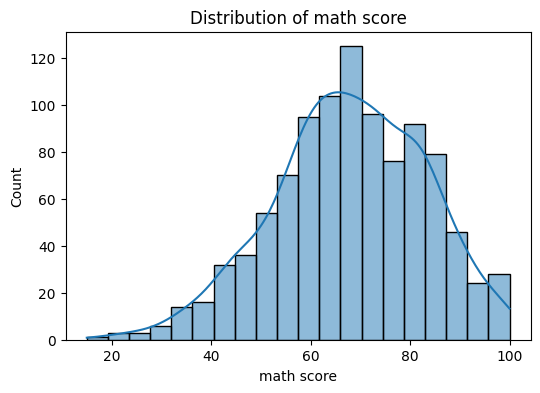

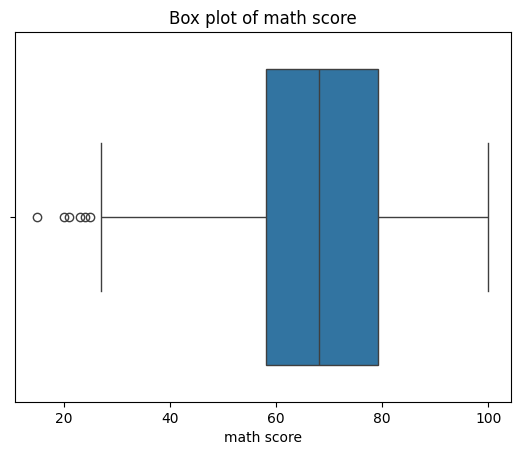

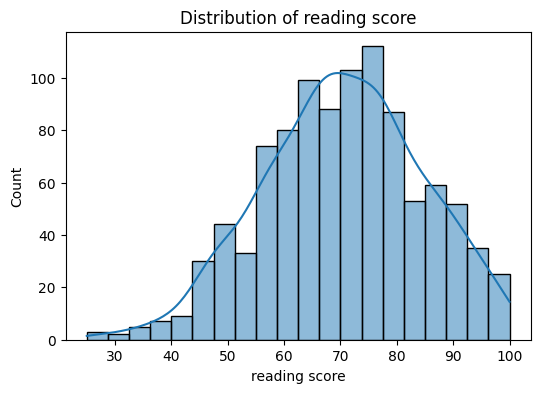

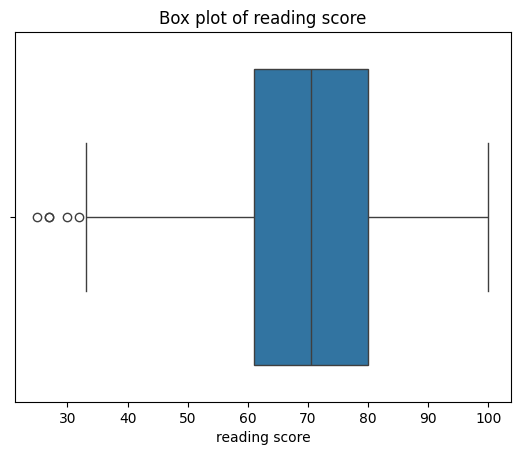

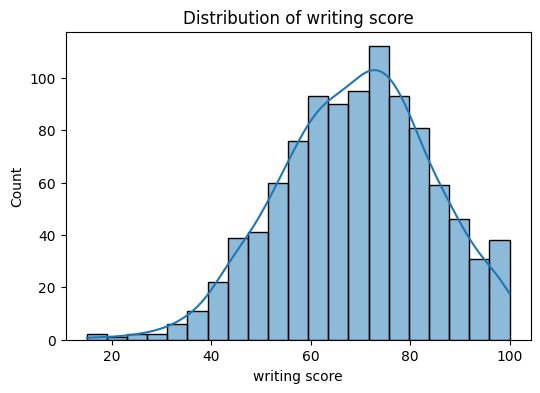

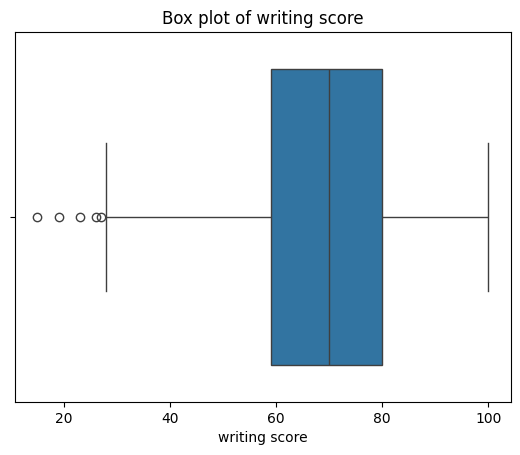

In [151]:
numerical_cols = ['math score', 'reading score', 'writing score']
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(exams_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    sns.boxplot(x=exams_df[col])
    plt.title(f'Box plot of {col}')
    plt.show()


In [152]:
# remove outliers
columns_to_check = [
    'gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'
]
z_scores = stats.zscore(exams_df[columns_to_check].select_dtypes(include=['float64', 'int64']), nan_policy='omit')
exams_df = exams_df[(abs(z_scores) < 3).all(axis=1)]

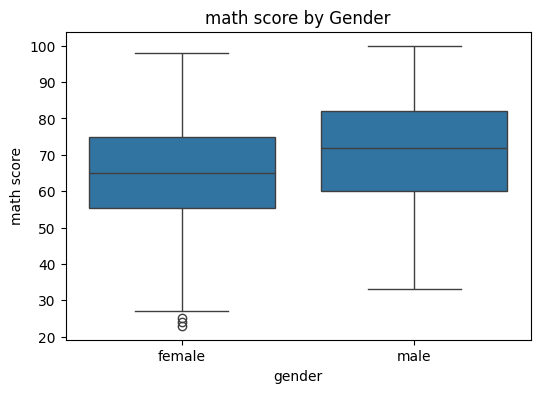

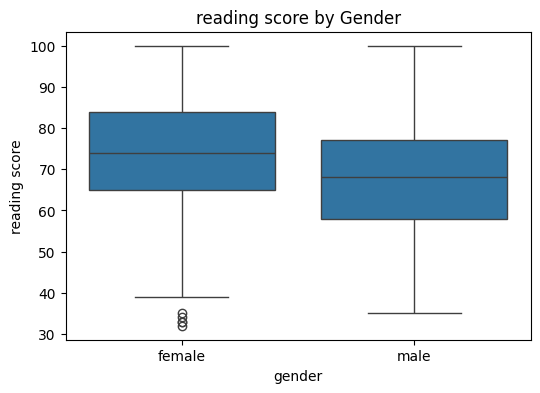

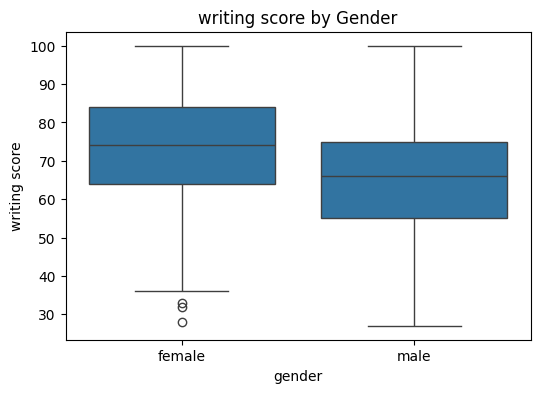

In [153]:
# analyze the relationship between gender and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='gender', y=col, data=exams_df)
    plt.title(f'{col} by Gender')
    plt.show()


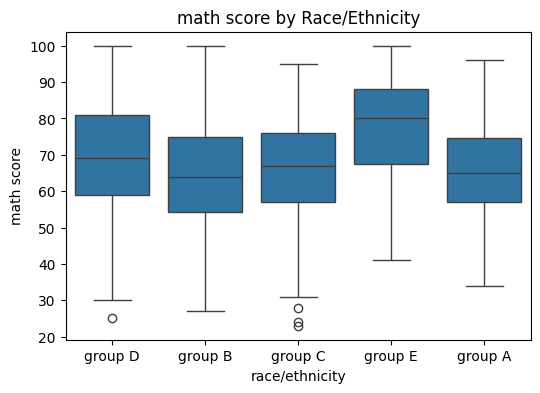

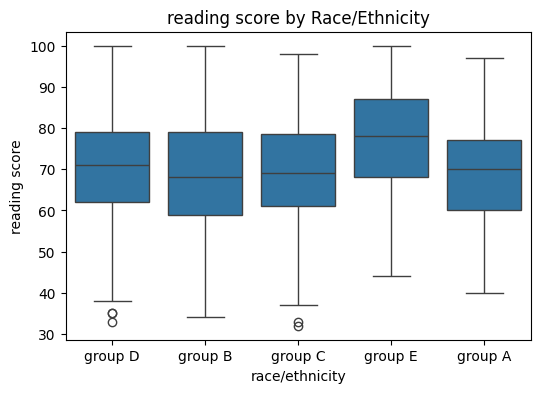

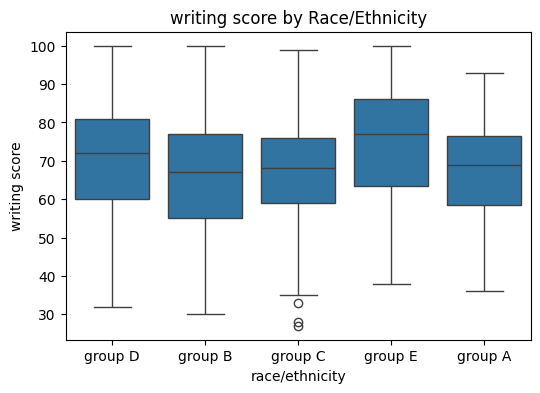

In [154]:
# analyze the relationship between race and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='race/ethnicity', y=col, data=exams_df)
    plt.title(f'{col} by Race/Ethnicity')
    plt.show()


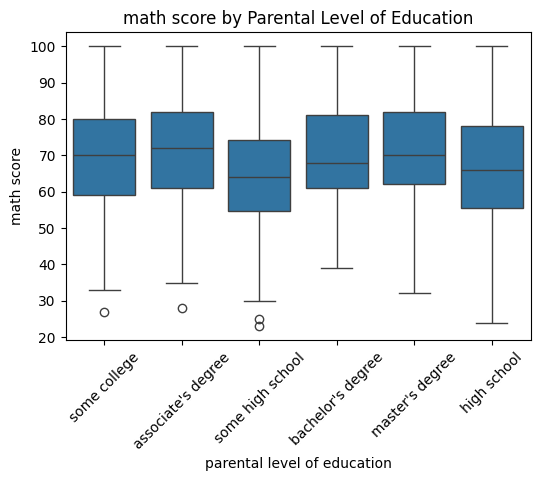

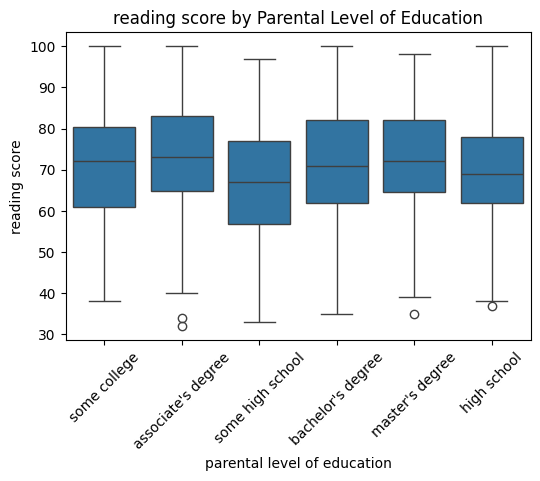

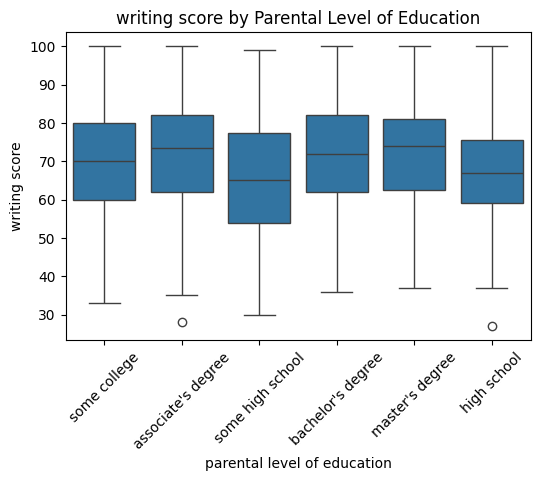

In [155]:
# analyze the relationship between parental education and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='parental level of education', y=col, data=exams_df)
    plt.xticks(rotation=45)
    plt.title(f'{col} by Parental Level of Education')
    plt.show()


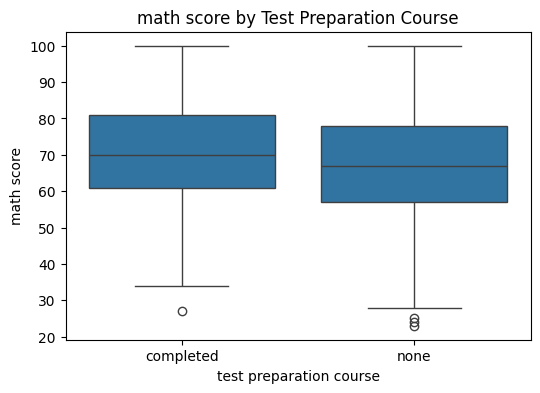

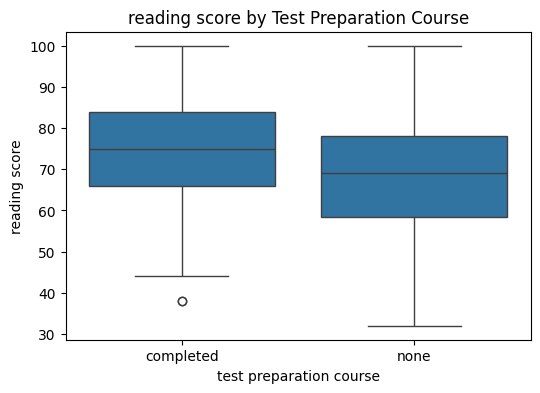

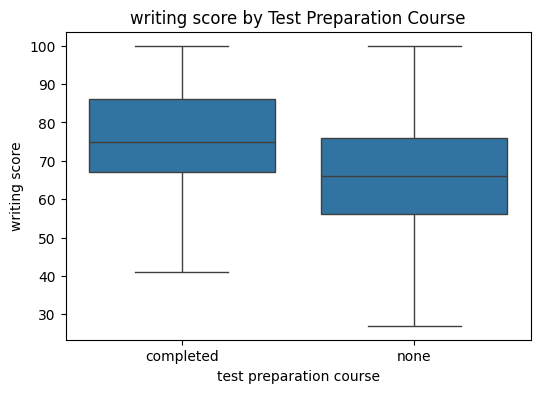

In [156]:
# analyze the relationship between test preparation course completion and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='test preparation course', y=col, data=exams_df)
    plt.title(f'{col} by Test Preparation Course')
    plt.show()


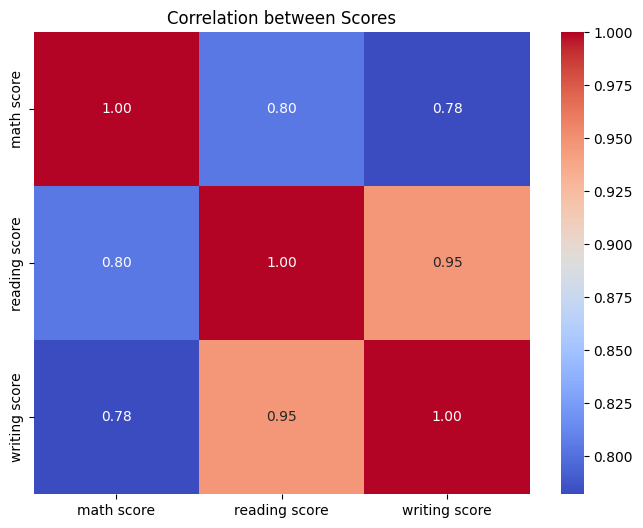

In [157]:
# Correlation heatmap between scores
plt.figure(figsize=(8, 6))
sns.heatmap(exams_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Scores')
plt.show()


In [158]:
target = 'reading score'

numerical_data = exams_df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

correlation = correlation_matrix['reading score'].abs().sort_values(ascending=False)
print(correlation)


reading score    1.000000
writing score    0.946702
math score       0.804398
Name: reading score, dtype: float64


In [159]:
# select features
features = ['math score', 'reading score']
target = 'writing score'

X = exams_df[features]
y = exams_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae_scores = {}
rmse_scores = {}

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features)
    ],
    remainder='passthrough'
)


def train_and_evaluate_model(model, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Apply preprocessing
        ('regressor', model)  # Use the specified model
    ])

    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store the results in the dictionaries
    mae_scores[model_name] = mae
    rmse_scores[model_name] = rmse



In [160]:
# For Linear Regression
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, 'Linear Regression')

# For Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
train_and_evaluate_model(tree_model, 'Decision Tree')

# For Random Forest
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [175]:
print("range of target score", exams_df['writing score'].min(), "-", exams_df['writing score'].max())
print("All MAE scores:", mae_scores)
print("All RMSE scores:", rmse_scores)

range of target score 27 - 100
All MAE scores: {'Linear Regression': 3.0915549389228136, 'Decision Tree': 3.692686357243321, 'Random Forest': 3.241505324492665}
All RMSE scores: {'Linear Regression': 3.675510327055055, 'Decision Tree': 4.673756418808482, 'Random Forest': 3.9079593866078954}


# student_data



secondary education of two Portuguese schools

In [162]:
large_df = pd.read_csv("/content/student_data.csv")
large_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [163]:
# large_df.info()
print("Columns: ", large_df.columns)
print("Record Count: ", len(large_df))

Columns:  Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')
Record Count:  395


In [164]:
# print(large_df.isnull().sum())

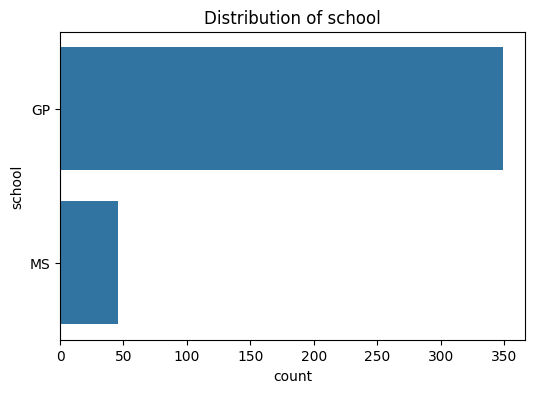

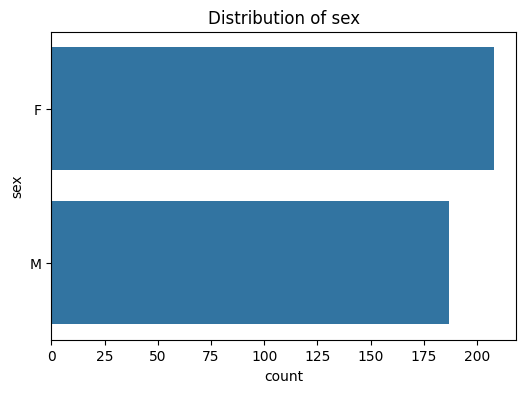

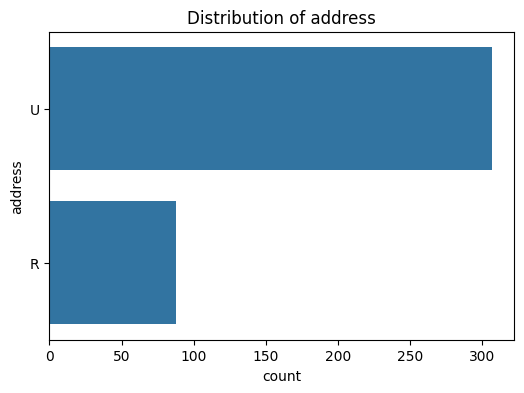

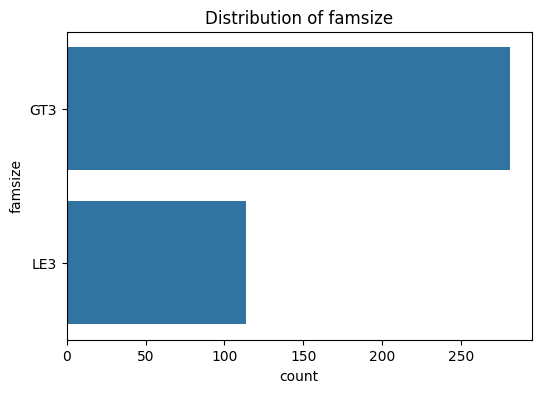

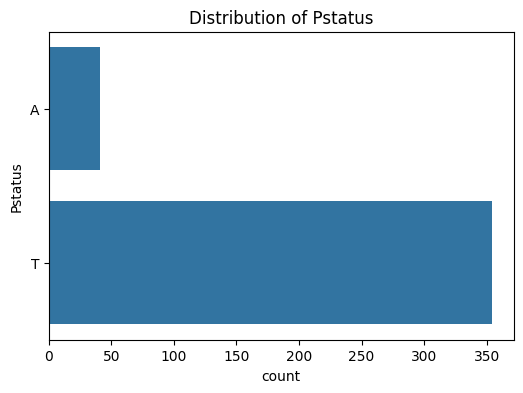

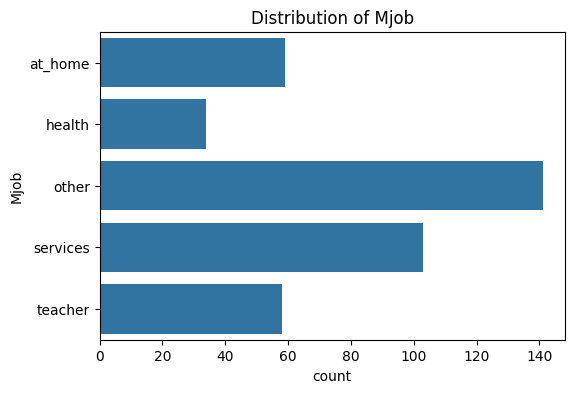

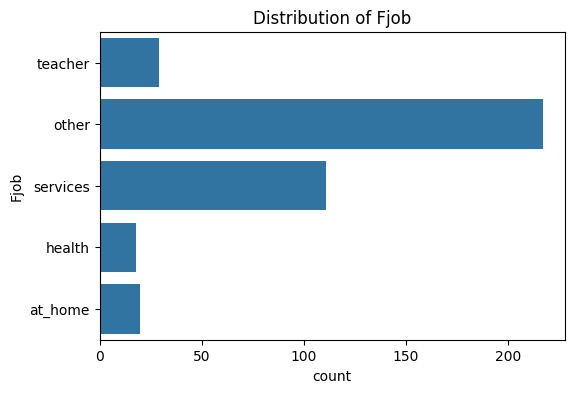

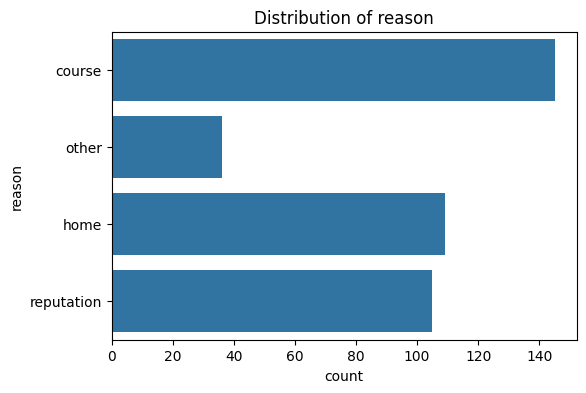

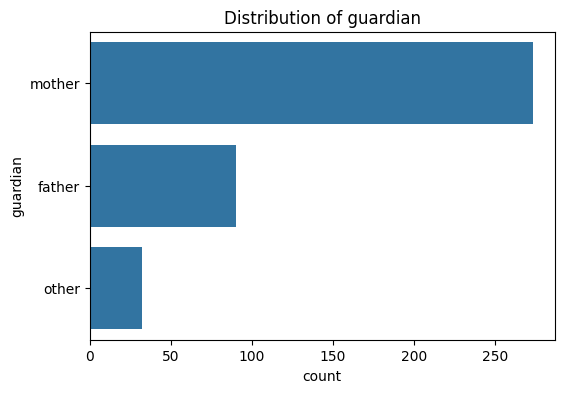

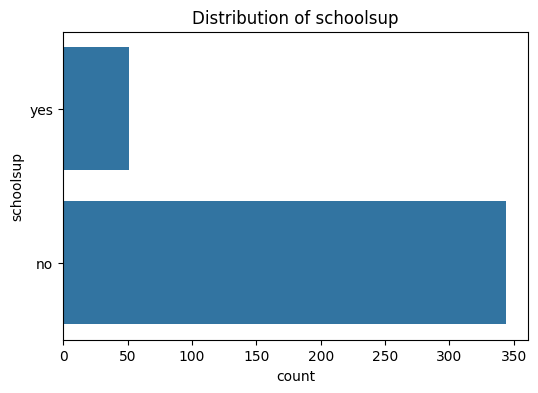

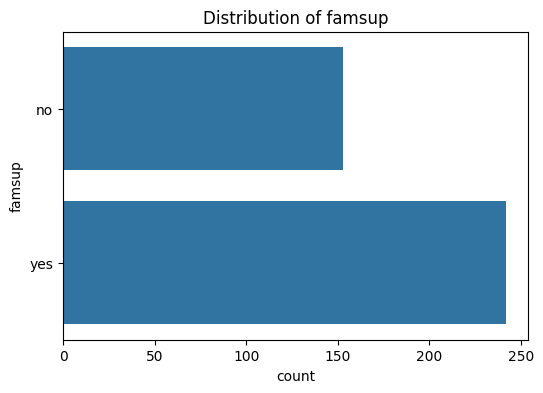

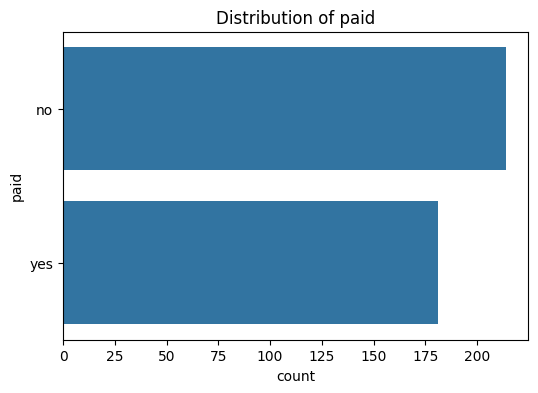

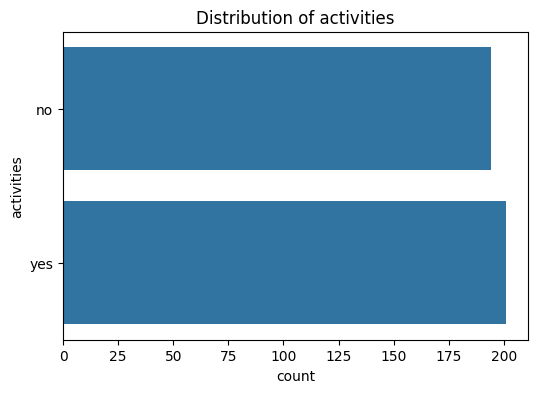

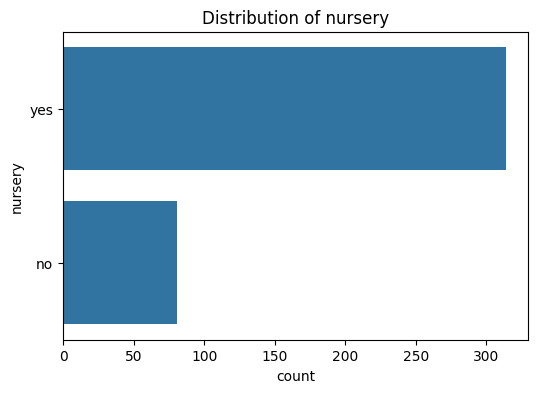

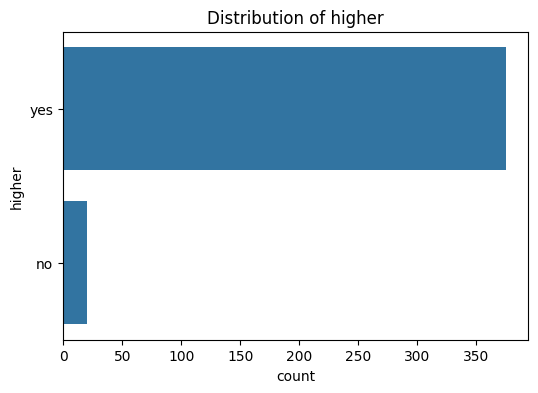

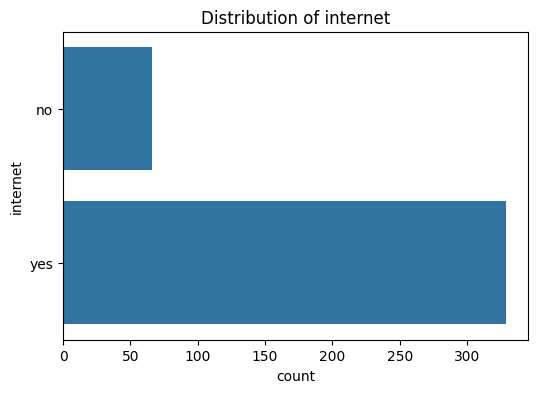

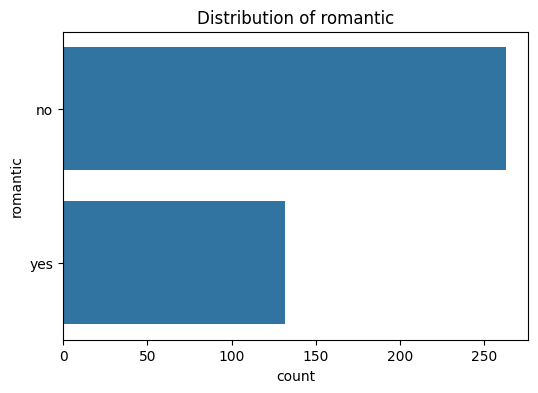

In [165]:
categorical_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic'
]

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(large_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()


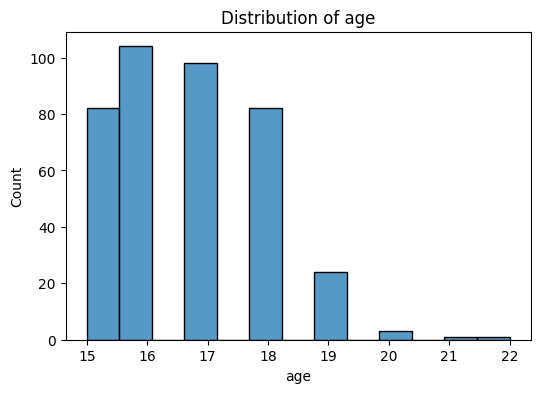

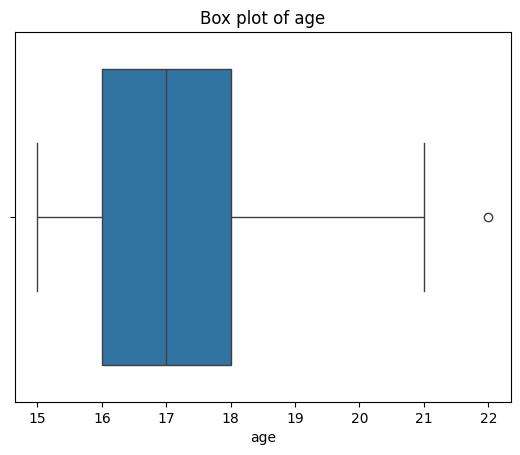

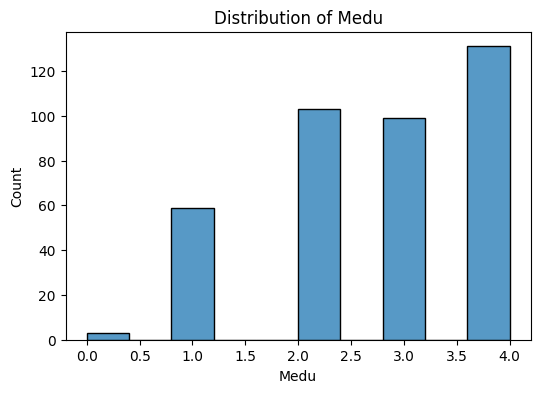

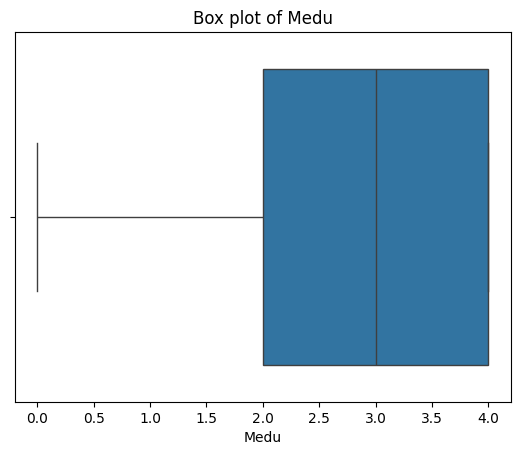

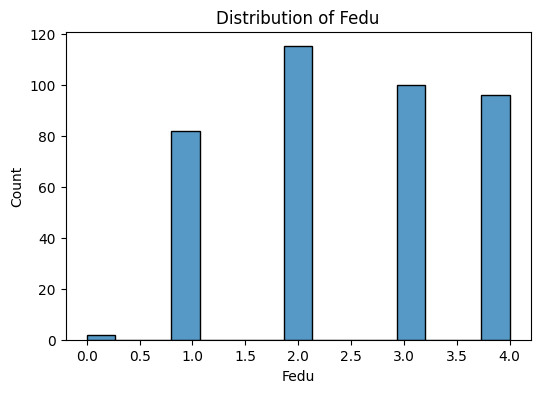

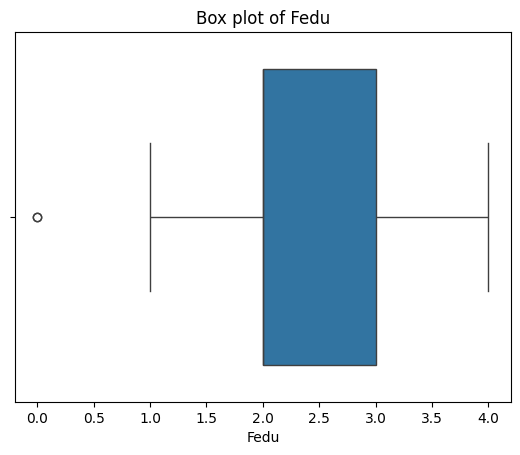

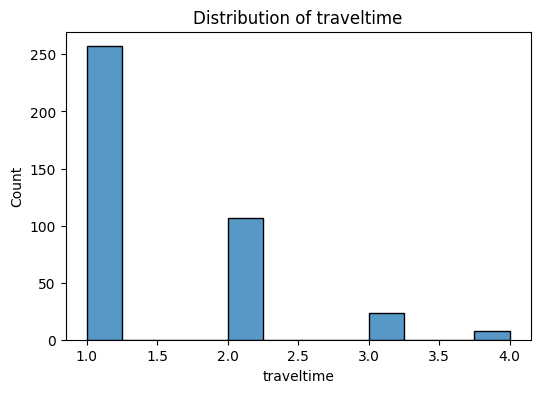

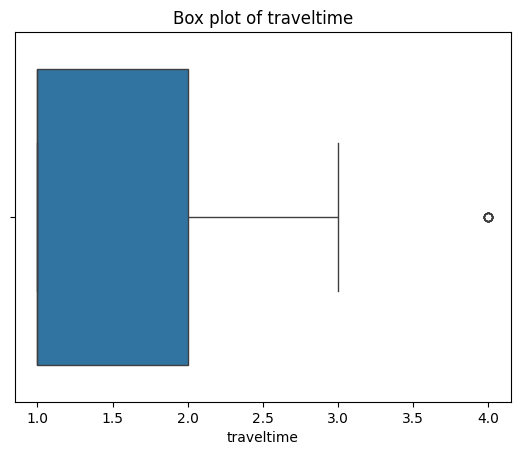

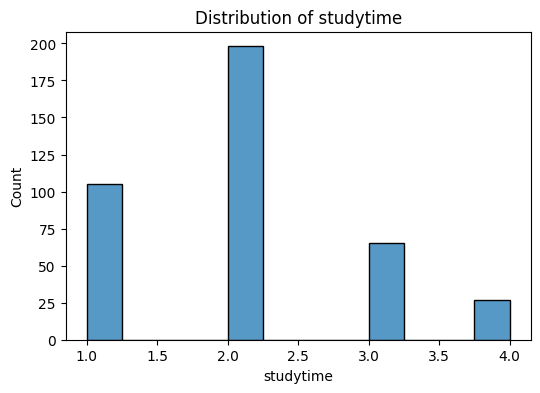

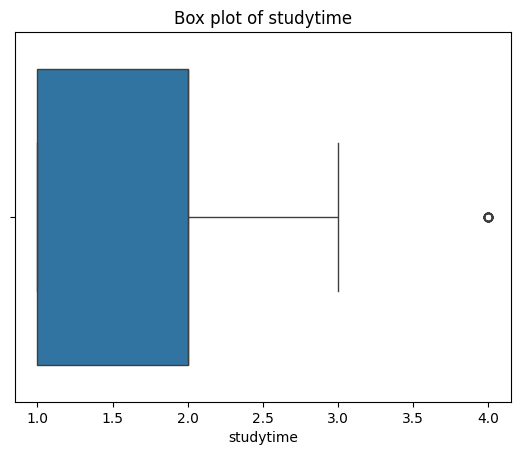

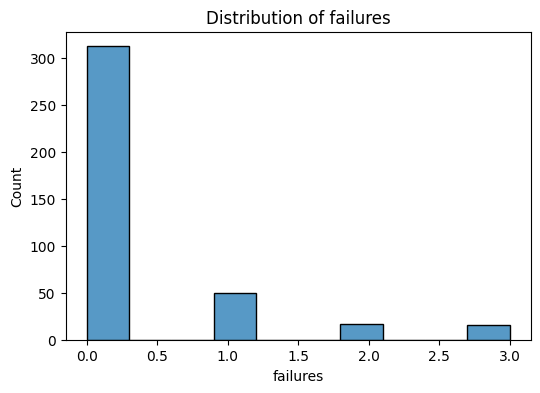

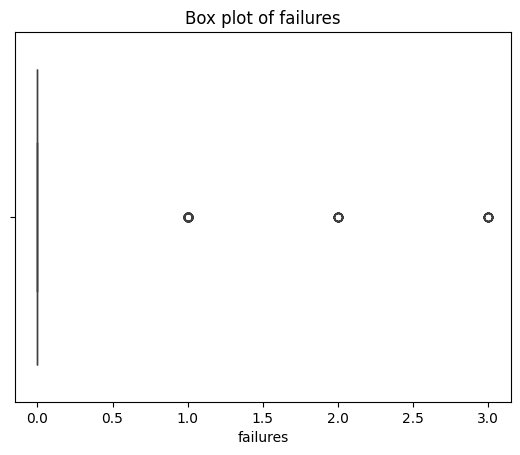

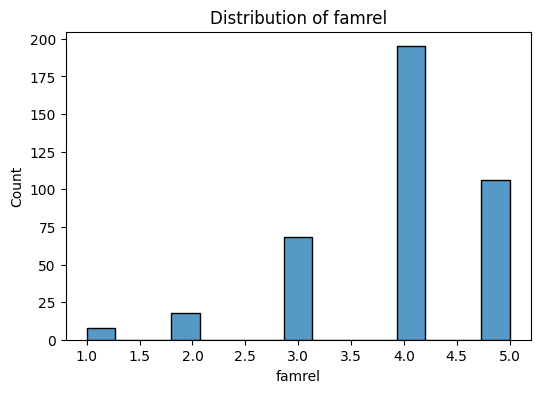

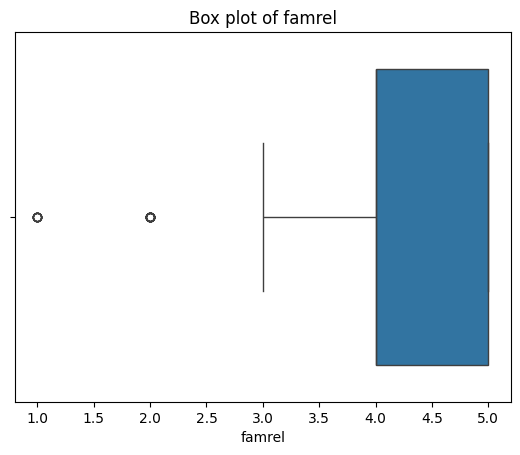

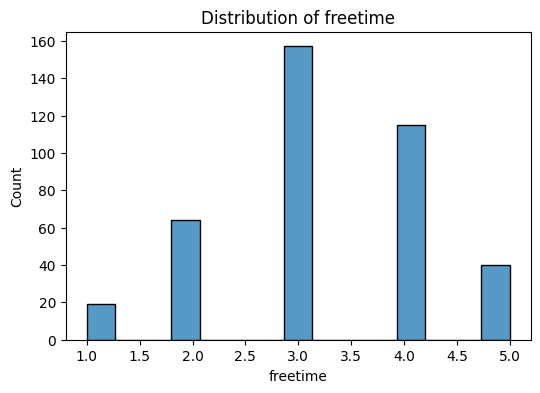

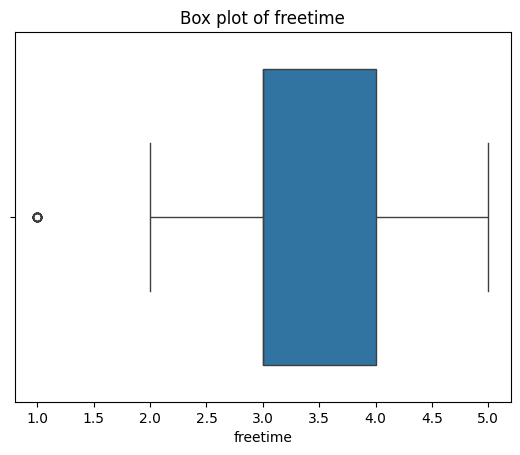

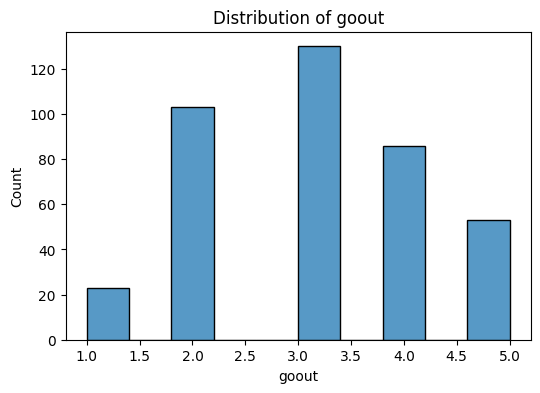

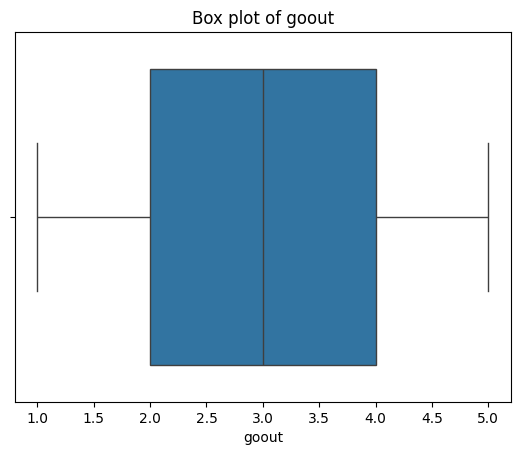

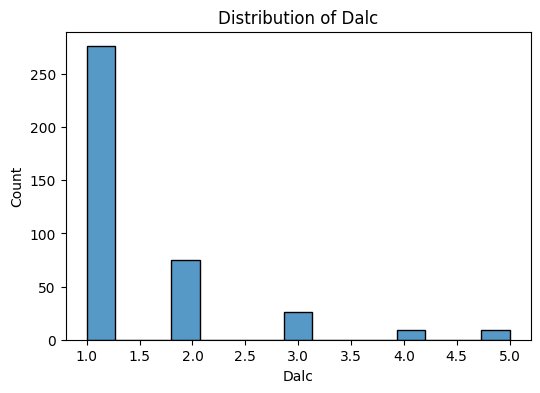

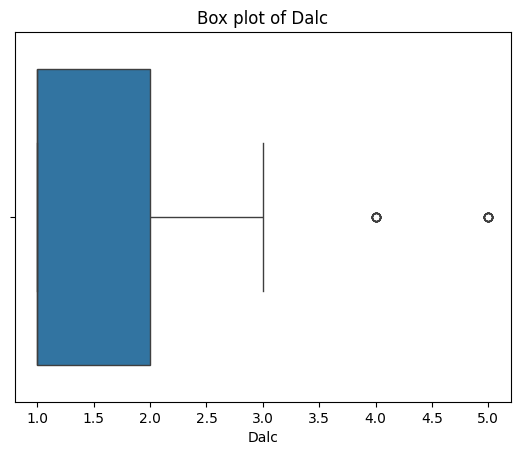

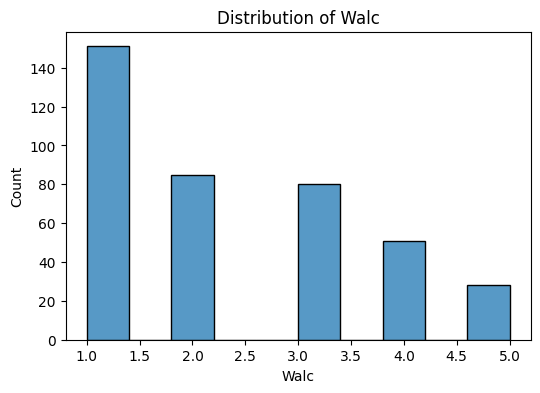

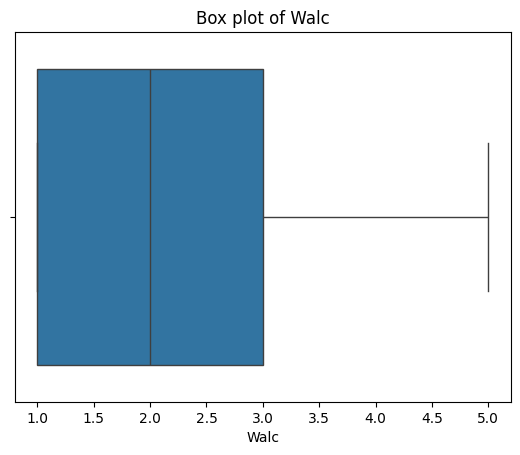

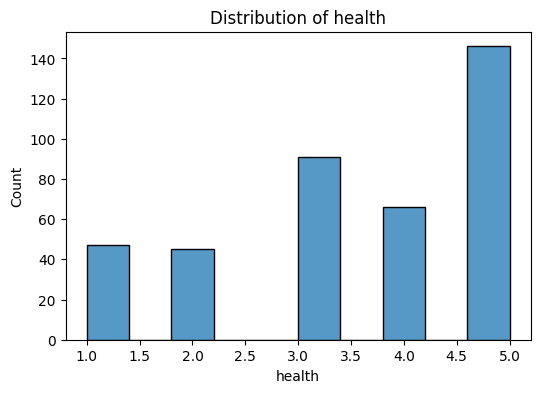

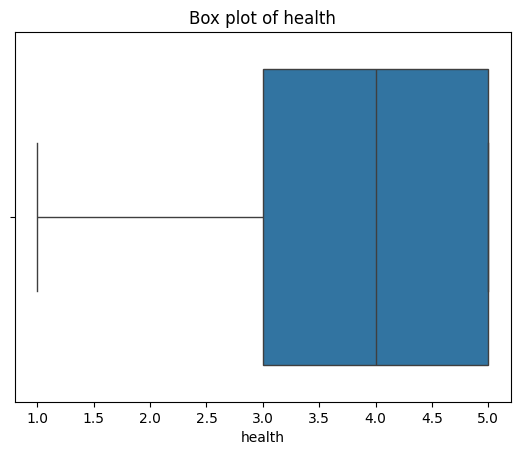

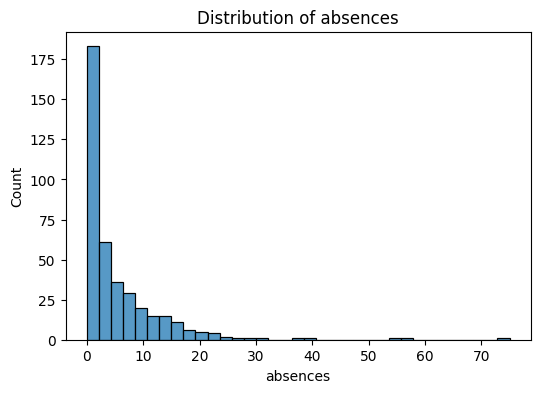

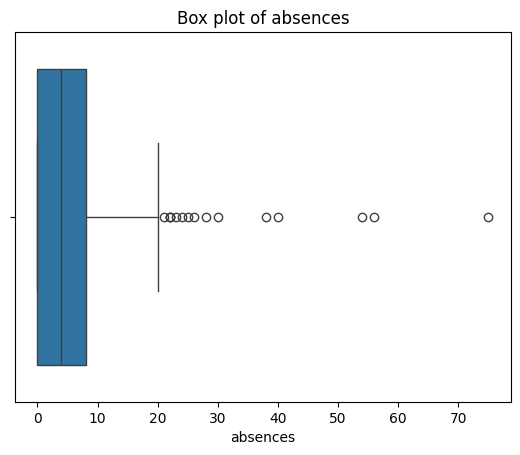

In [166]:
numerical_cols = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
    'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(large_df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

    sns.boxplot(x=large_df[col])
    plt.title(f'Box plot of {col}')
    plt.show()


In [167]:
grad_mean = (large_df.G1 + large_df.G2 + large_df.G3) / 3
large_df['G_Mean'] = grad_mean
large_df.drop(columns=['G1', 'G2', 'G3'], inplace=True)
large_df.head(4)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G_Mean
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,5.666667
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,5.333333
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,8.333333
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,14.666667


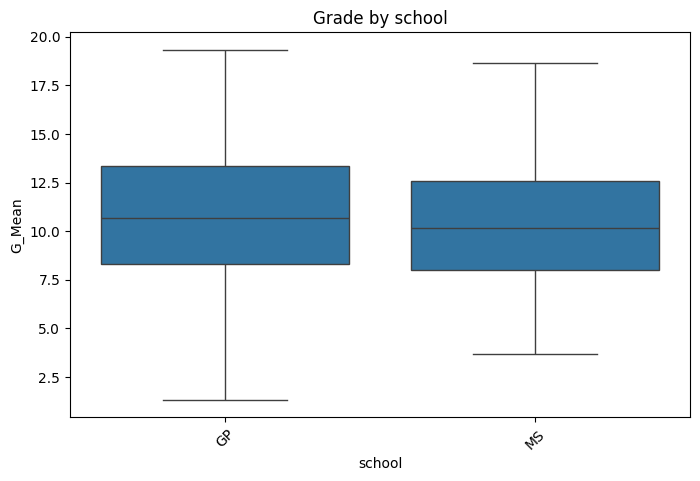

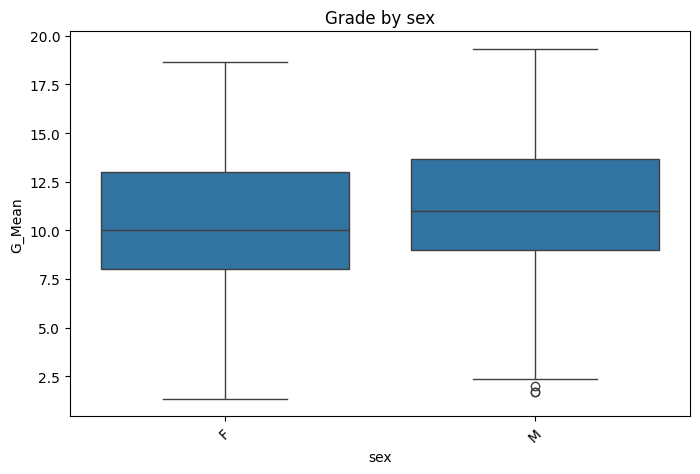

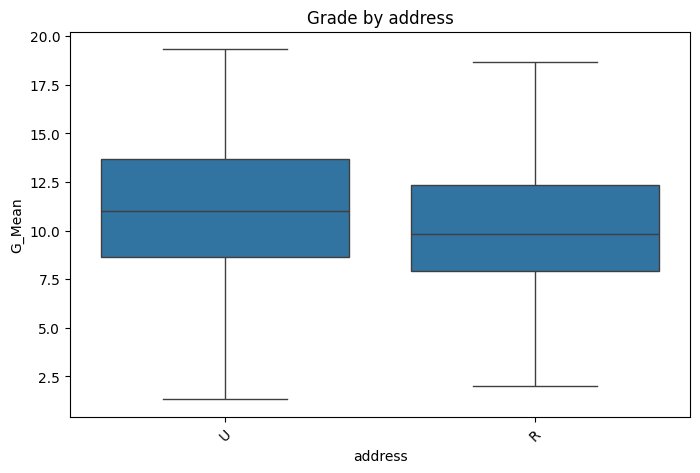

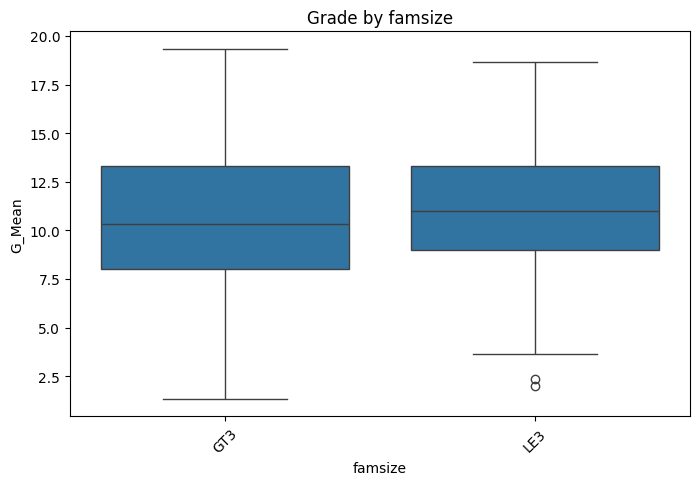

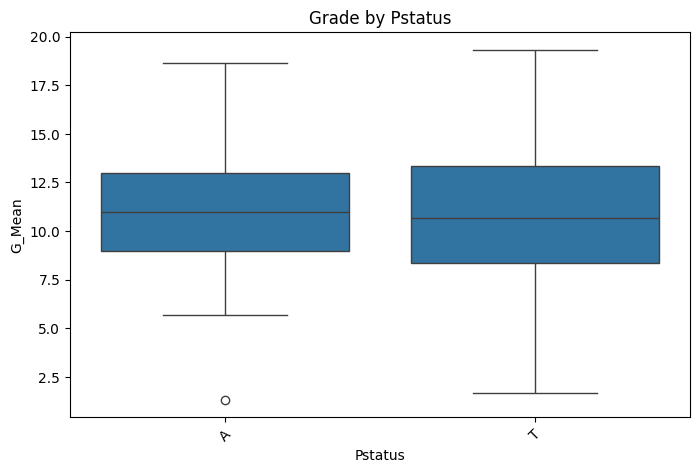

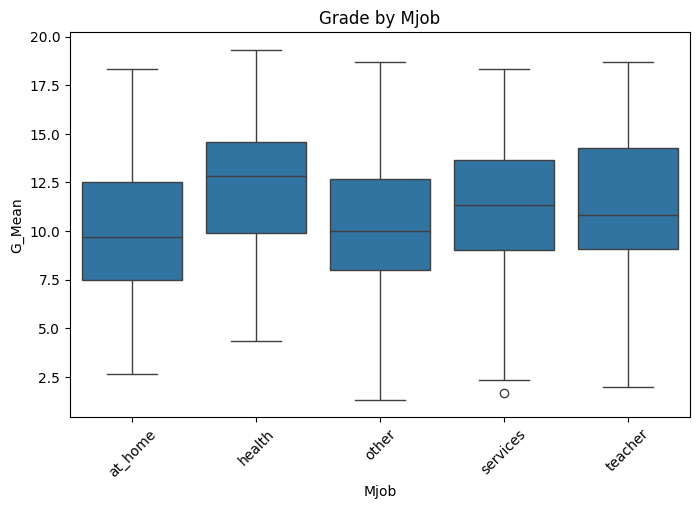

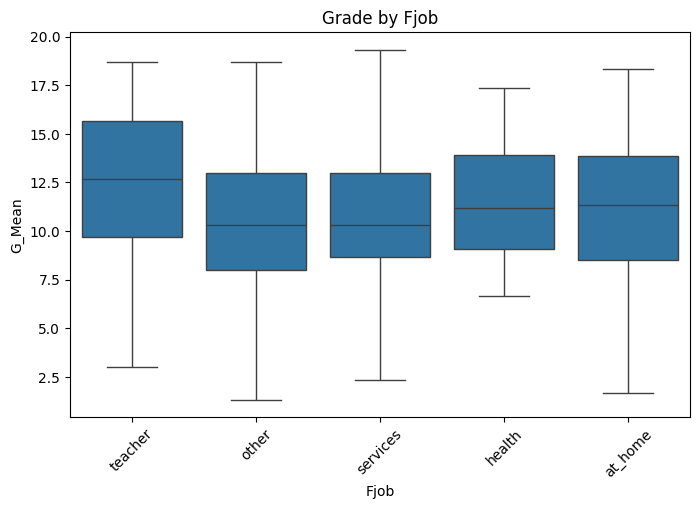

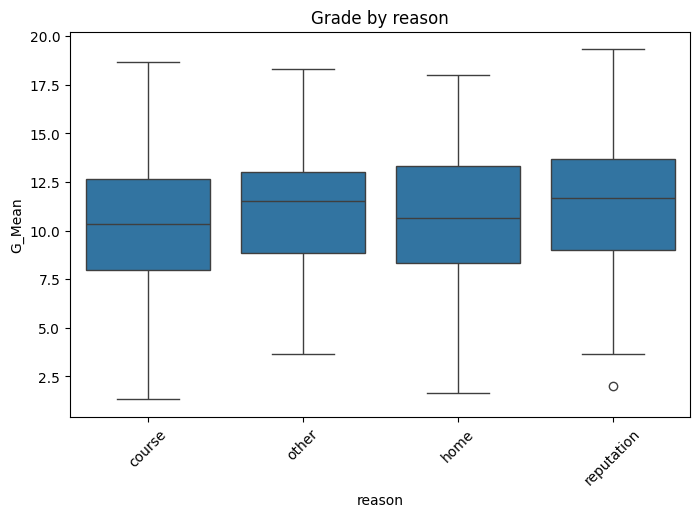

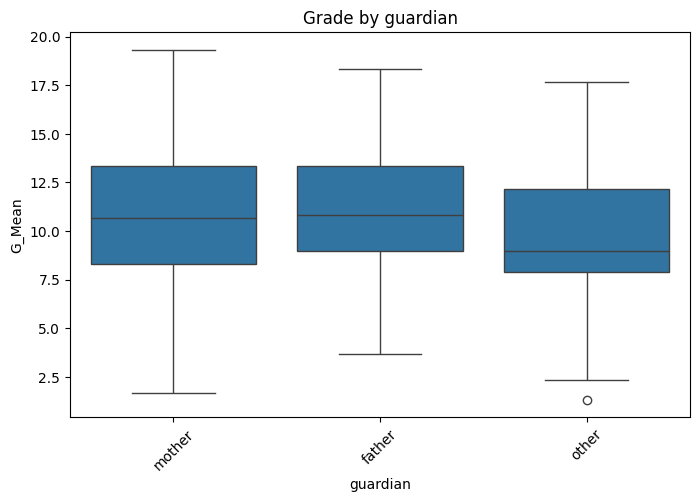

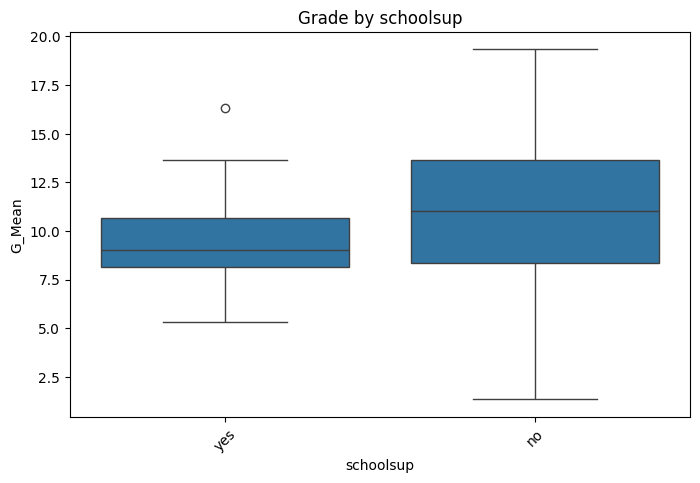

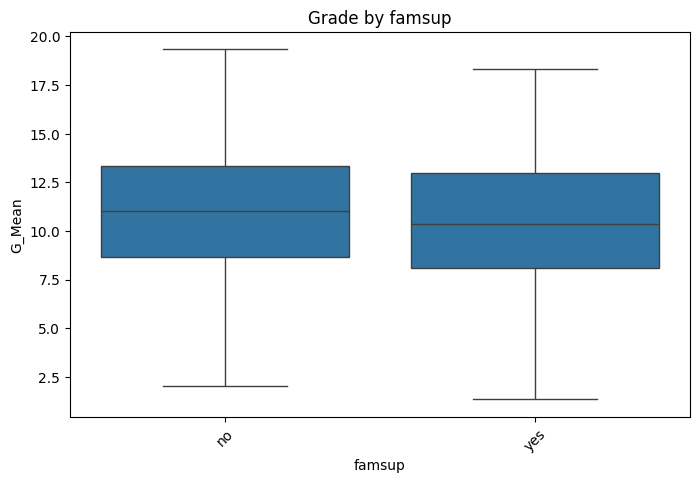

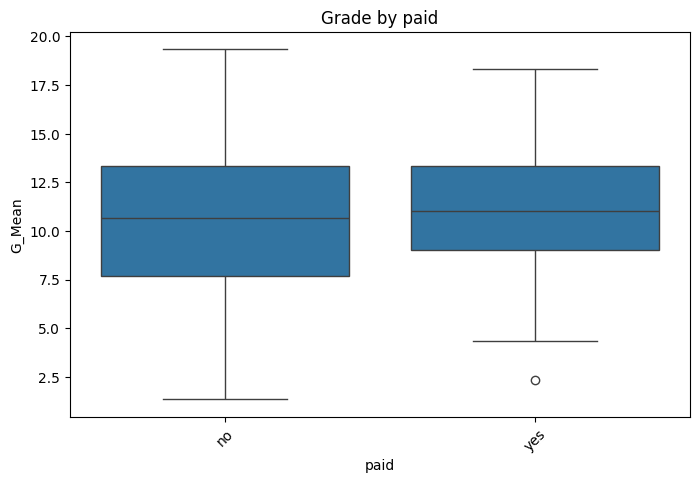

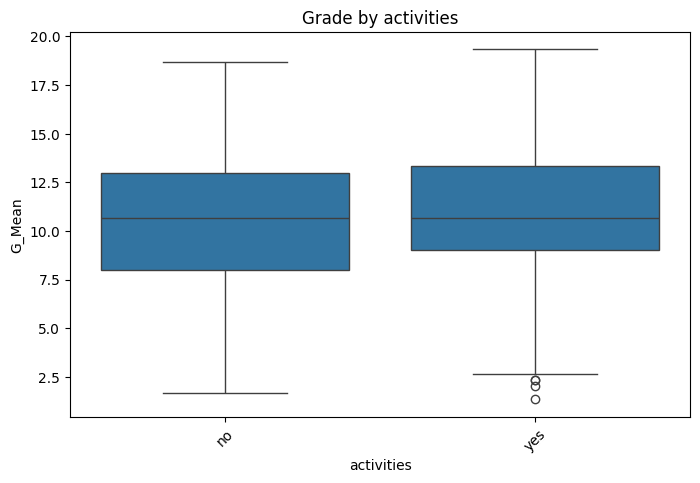

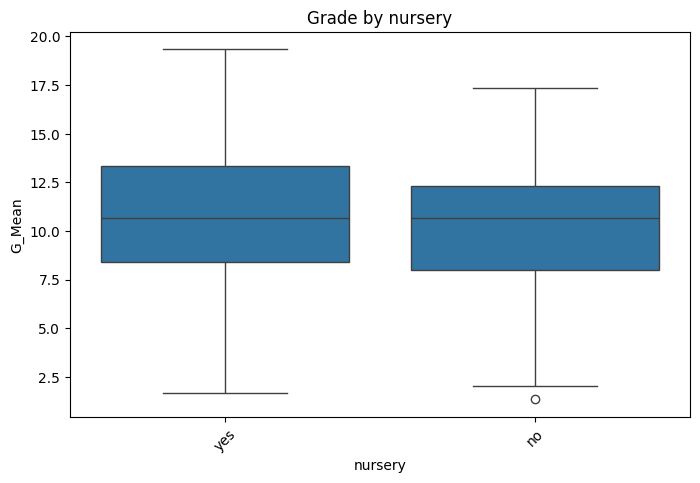

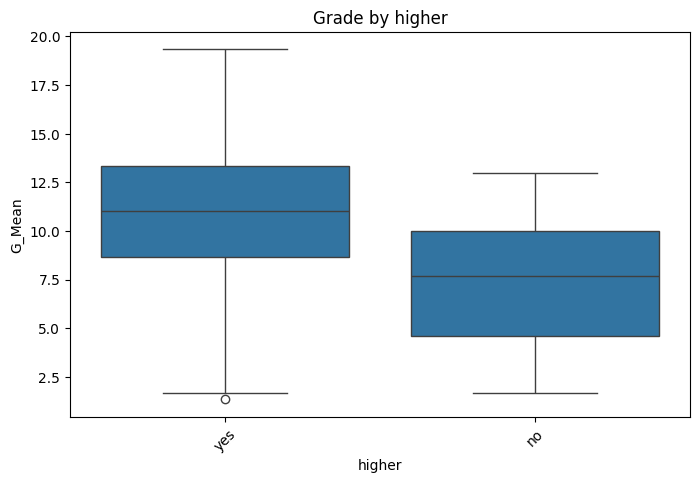

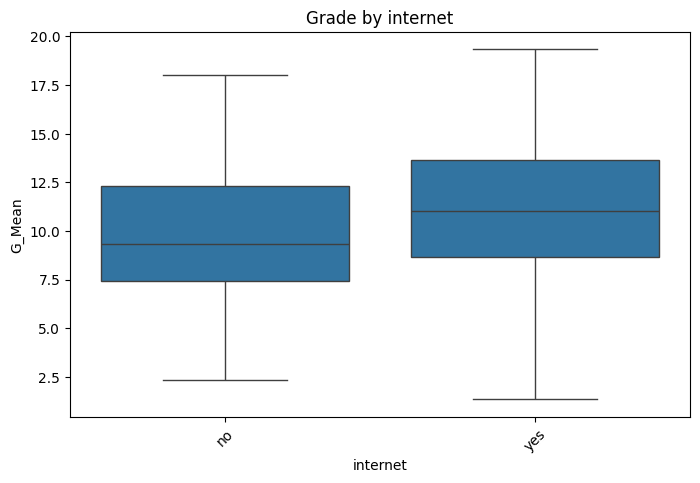

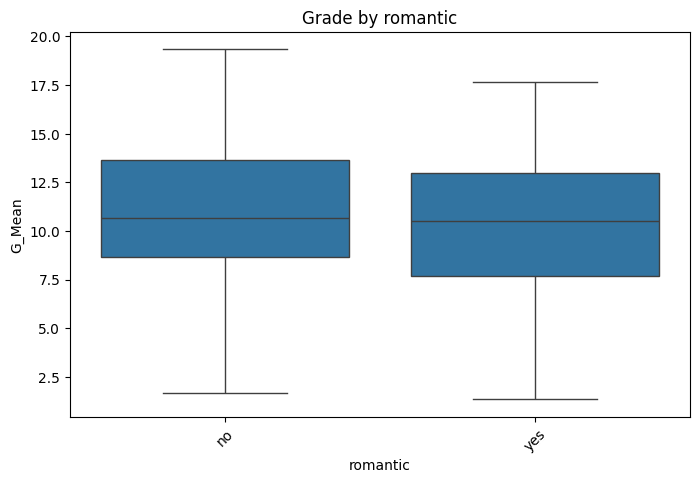

In [168]:
# categorical versus average grade
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='G_Mean', data=large_df)
    plt.title(f'Grade by {col}')
    plt.xticks(rotation=45)
    plt.show()


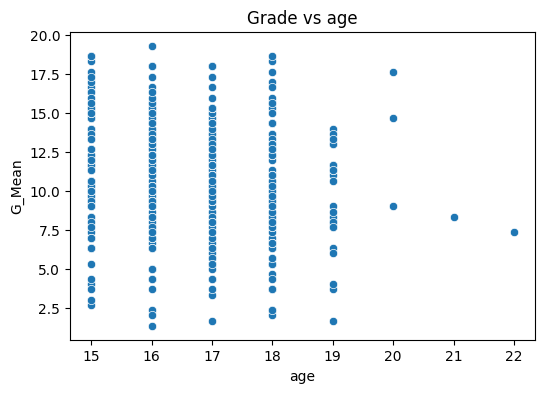

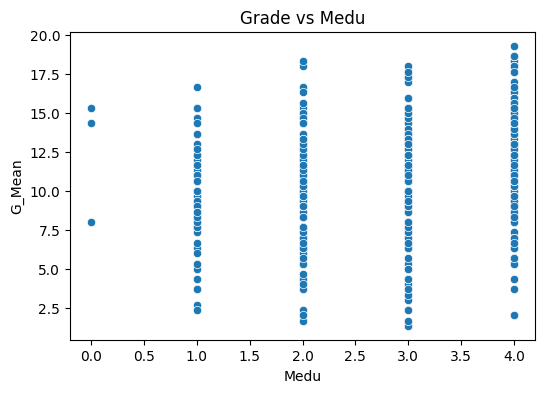

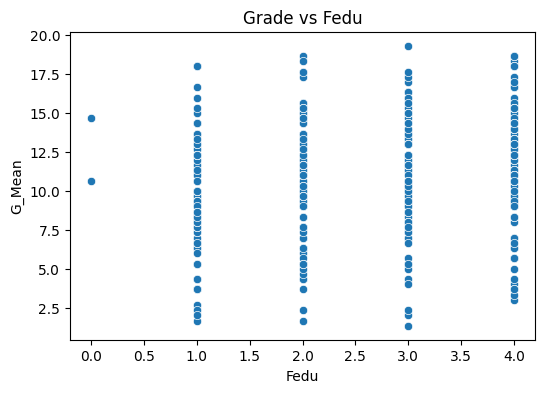

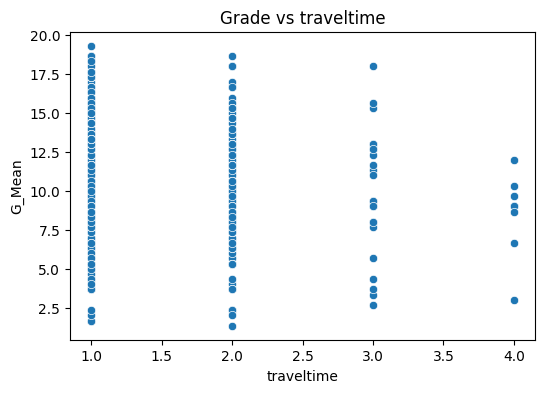

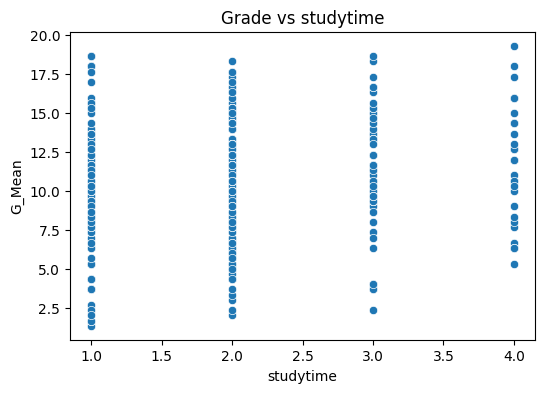

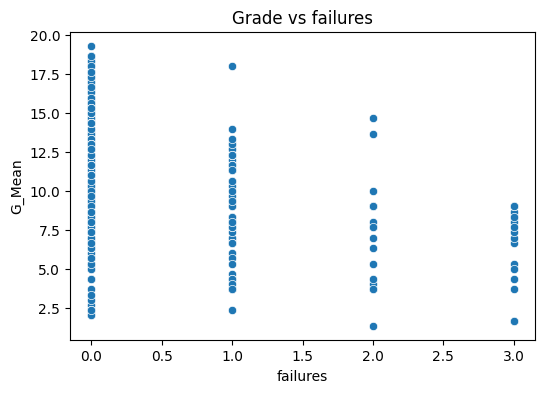

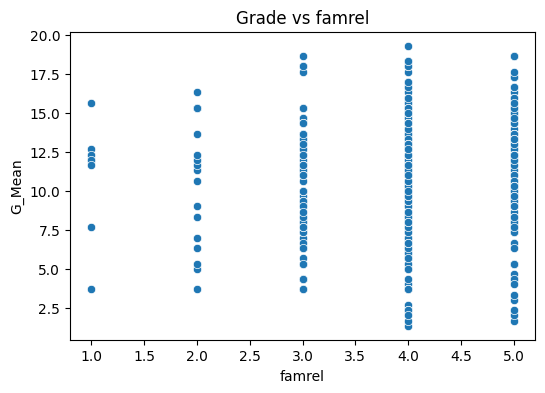

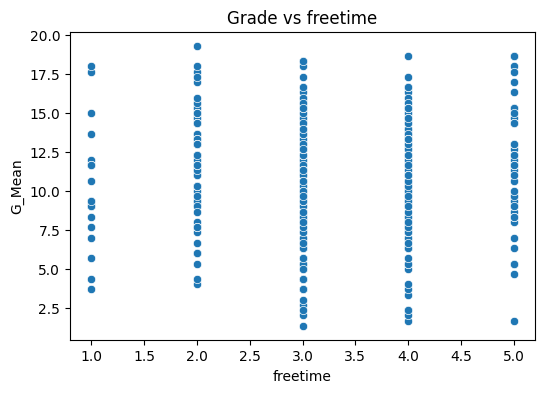

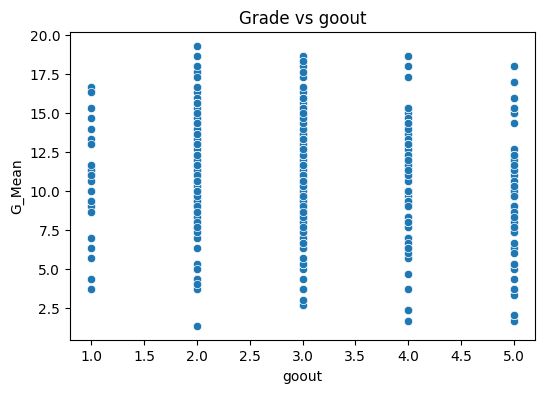

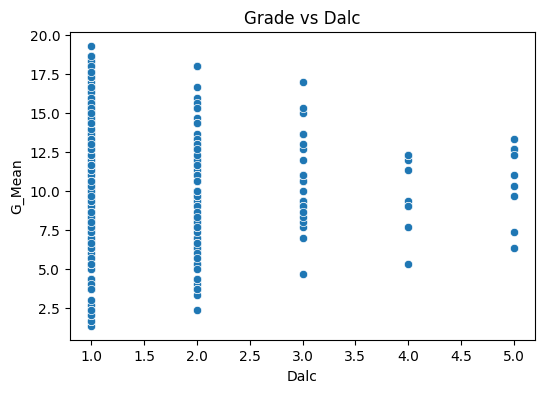

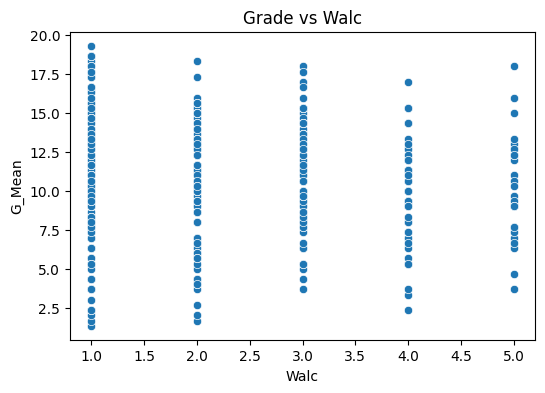

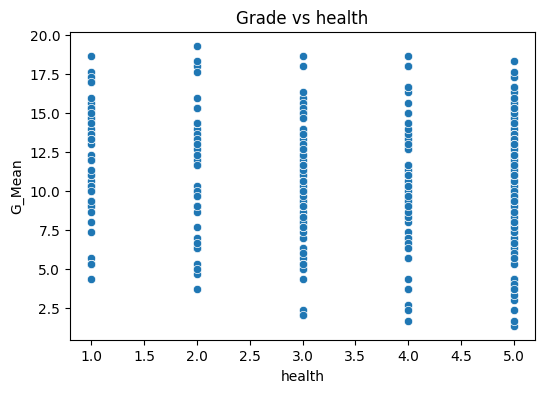

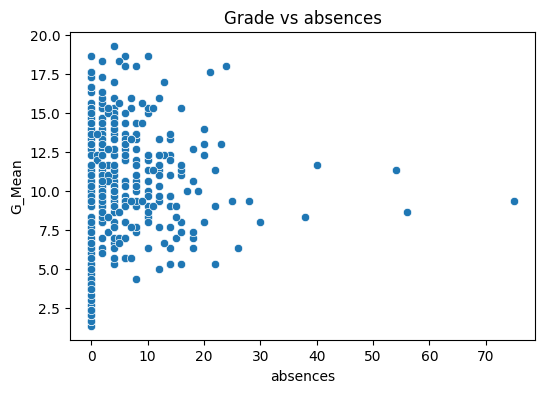

In [169]:
# numerical versus average grade
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=col, y='G_Mean', data=large_df)
    plt.title(f'Grade vs {col}')
    plt.show()


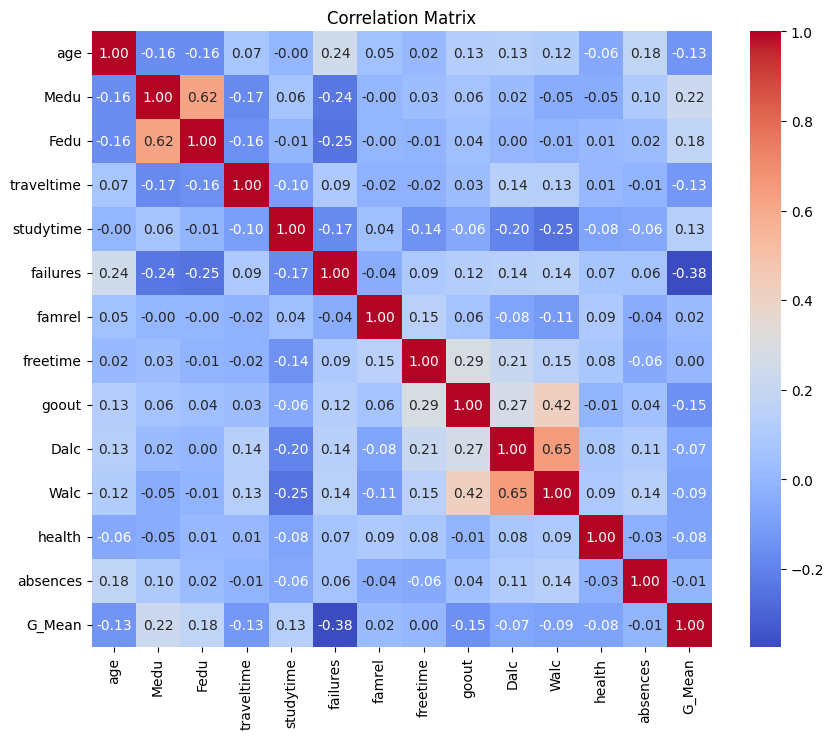

G_Mean        1.000000
failures      0.375759
Medu          0.224260
Fedu          0.175852
goout         0.154511
age           0.134589
studytime     0.134565
traveltime    0.128197
Walc          0.088025
health        0.080380
Dalc          0.072508
famrel        0.021653
absences      0.005909
freetime      0.003773
Name: G_Mean, dtype: float64


In [170]:
# Correlation heatmap
numerical_data = large_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


correlation_matrix = numerical_data.corr()
correlation = correlation_matrix['G_Mean'].abs().sort_values(ascending=False)
print(correlation)


In [171]:
# using the Python Predictive Power Score (PPS)
pps_matrix = pps.matrix(large_df)
pps_df = pd.DataFrame(pps_matrix)
# pps_df.loc[pps_df['x'] == 'G_Mean']
pps_df.loc[(pps_df['x'] == 'G_Mean') & (pps_df['ppscore'] != 0.0)]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
935,G_Mean,Pstatus,0.064255,classification,True,weighted F1,0.847145,0.856966,DecisionTreeClassifier()
939,G_Mean,Fjob,0.100538,classification,True,weighted F1,0.389873,0.451214,DecisionTreeClassifier()
940,G_Mean,reason,0.022537,classification,True,weighted F1,0.270886,0.287318,DecisionTreeClassifier()
941,G_Mean,guardian,0.018960,classification,True,weighted F1,0.564913,0.573163,DecisionTreeClassifier()
946,G_Mean,famsup,0.072943,classification,True,weighted F1,0.503797,0.539992,DecisionTreeClassifier()
947,G_Mean,paid,0.076266,classification,True,weighted F1,0.508861,0.546318,DecisionTreeClassifier()
948,G_Mean,activities,0.076760,classification,True,weighted F1,0.483544,0.523187,DecisionTreeClassifier()
952,G_Mean,romantic,0.082693,classification,True,weighted F1,0.532253,0.570933,DecisionTreeClassifier()
960,G_Mean,G_Mean,1.000000,predict_itself,True,None,0.000000,1.000000,None


In [172]:
# select features
features = ['Medu', 'Fedu', 'studytime', 'failures', 'goout', 'age', 'traveltime']
# features = ['Pstatus', 'Fjob', 'reason', 'guardian', 'famsup', 'paid', 'activities', 'romantic']
target = 'G_Mean'


X = large_df[features]
y = large_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae_scores = {}
rmse_scores = {}

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features)
    ],
    remainder='passthrough'
)


def train_and_evaluate_model(model, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Apply preprocessing
        ('regressor', model)  # Use the specified model
    ])

    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store the results in the dictionaries
    mae_scores[model_name] = mae
    rmse_scores[model_name] = rmse



In [173]:
# For Linear Regression
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, 'Linear Regression')

# For Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
train_and_evaluate_model(tree_model, 'Decision Tree')

# For Random Forest
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest')

In [174]:
print("range of G_mean score", large_df['G_Mean'].min(), large_df['G_Mean'].max())
print("All MAE scores:", mae_scores)
print("All RMSE scores:", rmse_scores)

# Using the PPScore:
# All MAE scores: {'Linear Regression': 3.167104478444318, 'Decision Tree': 4.064275668073138, 'Random Forest': 3.55830285847877}
# All RMSE scores: {'Linear Regression': 3.8056455022703086, 'Decision Tree': 5.014323833459296, 'Random Forest': 4.455727358821661}

range of G_mean score 1.3333333333333333 19.333333333333332
All MAE scores: {'Linear Regression': 3.0915549389228136, 'Decision Tree': 3.692686357243321, 'Random Forest': 3.241505324492665}
All RMSE scores: {'Linear Regression': 3.675510327055055, 'Decision Tree': 4.673756418808482, 'Random Forest': 3.9079593866078954}
